In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In order to start, we have to define the equation that defines the projectile motion of the ball. In order to do this I will define the forces that act on the ball seperately to simplify the final equation.

According to NASA (https://www.grc.nasa.gov/WWW/K-12/airplane/balldrag.html) the drag coefficient on a baseball is equal to 0.3
Similarly according to NASA (https://www.grc.nasa.gov/WWW/K-12/airplane/balllift.html) the lift coefficient on a baseball is 0.15

It is also important to note that a baseball's circumfrence and mass are not constant for all baseballs, instead they fall inside a tolerance. The range for radius is .229-.235 meters and the mass is .142-.149 kg (https://en.wikipedia.org/wiki/Baseball_(ball)#:~:targetText=Under%20the%20current%20rules%2C%20a,%E2%80%9376%20mm%20in%20diameter). We will just be using the middle of the range as an approximation; i.e .232 m and .1455 kg

For air density, we will just be using the values provided here (https://www.purplerow.com/2018/1/8/16846116/colorado-rockies-coors-field-arizona-diamondbacks-chase-field-comparison#:~:targetText=On%20a%20typical%20summer%20day,has%20an%20air%20density%20of%20.) This also provides us with an air density for San Diego which we will use as our control.

Average Pitch Height of 1.14 meters

In [285]:
#Here we will be defining a bunch of constants used later in case we want to change them.
Cd= 0.3
Cl=0.15
mass= .1455
Rball = .232/(2*np.pi)
CrossA= np.pi* Rball**2
g=-9.8
Airdensea= 1.182 
Airdenco= .966 
z0=1.14

termvsea=(np.sqrt ( (2 * mass * g) / (Cd * Airdensea * CrossA) ))
termvco=(np.sqrt ( (2 * mass * g) / (Cd * Airdenco * CrossA) ))


In [286]:
def terminaldrag(Location): #Arg requires either co or sea for the two heights
    if Location == "co":
        return(.5*Cd*Airdenco*CrossA*termvco**2)
    elif Location == "sea":
        return(.5*Cd*Airdensea*CrossA*termvsea**2)

def drag(vel,Location):
    if Location == "co":
        return (.5*Cd*Airdenco*CrossA*(vel**2))
    elif Location == "sea":
        return (.5*Cd*Airdensea*CrossA*(vel**2))
    
def lift(vel,spin,Location):
    if Location == 'co':
        return(Cl*(4 * np.pi**2 * Rball**3 * spin * Airdenco * vel) * (4/3))
    elif Location == 'sea':
        return(Cl*(4 * np.pi**2 * Rball**3 * spin * Airdensea * vel) * (4/3))


def ascensionf(vel, Location):
    if Location == 'co':
        return( (mass*g) - drag(vel, Location))
    elif Location =="sea":
        return( (mass*g) - drag(vel, Location))
    

In [287]:
def Baseballflight(t, y, spin, Location):
    '''y is an array with [X0,Y0,Vx,Vy]'''
    
    dydt= np.zeros(4)
    
    dydt[1]=y[3]
    if y[3]>=0:
        dydt[3]= (ascensionf(y[3],Location)+lift(y[2],spin,Location))/mass
    elif y[3]<0:
        dydt[3]= ((mass*g)+drag(y[3],Location)+lift(y[2],spin,Location))/mass
    dydt[0]=y[2]
    dydt[2]= -drag(y[2],Location)/mass
    return(dydt)

Now I will be including the Runga Kutta method as a way to solve these equations. I will be largely using the code Professor Miller Provided in his example on the Runga Kutta Method.

In [288]:
def RungeKutta4(func, y_0, t, spin, Location):
    """ Classical Runge-Kutta (RK4) approximation to a first-order ODE system
    with initial conditions.

    Args:
        func: (callable) The first-order ODE system to be approximated.
        y_0:  (array)    The initial condition.
        t:    (array)    A sequence of time points for which to solve for y.
        args: (dict)     Extra arguments to pass to function.

    Out:
        y:    (array)    The approximated solution of the system at each time in t,
                         with the initial value y_0 in the first row.
    """

    # Initialise the approximation array
    y = np.zeros([len(t), len(y_0)])
    y[0] = y_0

    # Loop through the time steps, approximating this step from the prev step
    for i, t_i in enumerate(t[:-1]):
        if y[i][1]<=0:
            return(y)
        else:
            h   = t[i+1] - t_i # size of the step

            k_1 = h*func(t_i, y[i], spin, Location)
            k_2 = h*func(t_i + h/2. , y[i] + k_1/2., spin, Location)
            k_3 = h*func(t_i + h/2. , y[i] + k_2/2., spin, Location)
            k_4 = h*func(t_i + h    , y[i] + k_3, spin, Location)

            y[i+1] = y[i] + 1/6.*(k_1 + 2.*k_2 + 2.*k_3 + k_4) # RK4 step
        
    return y

In [289]:
N     = 50 # Num of steps to take
t_max = 7.5 # Limit of the range to evaluate the function
T    = np.linspace(0., t_max, N+1) # Array of discretized steps


y_0= np.array([0,1.14,49*np.cos(27*np.pi/180),49*np.sin(27*np.pi/180)])
ysea= RungeKutta4(Baseballflight,y_0,T,41,'sea')
yco=RungeKutta4(Baseballflight,y_0,T,41,'co')

In [360]:
def Cleanerfunc(array):
    temp=array.tolist()
    counter=0
    for k in temp:
        if k[2]==0:
            counter+=1
    for l in range(counter):
        temp.remove([0.0,0.0,0.0,0.0])
    final=np.asarray(temp)       
    return(final)

In [361]:
Seaclean=Cleanerfunc(ysea)

Coclean=Cleanerfunc(yco)

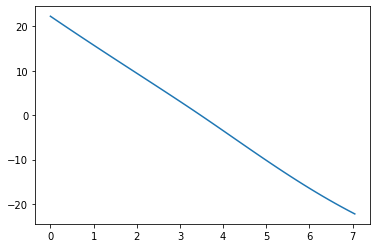

In [365]:
plt.plot(T[:len(Seaclean)],Seaclean[:,3])

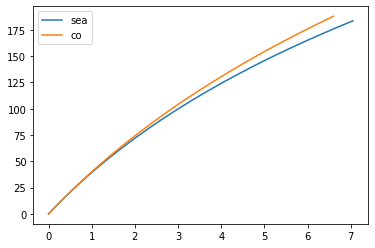

In [366]:
plt.plot(T[:len(Seaclean)],Seaclean[:,0],label='sea')
plt.plot(T[:len(Coclean)],Coclean[:,0],label='co')
plt.legend()

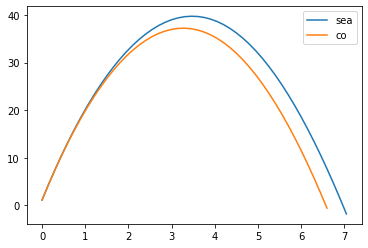

In [369]:
plt.plot(T[:len(Seaclean)],Seaclean[:,1],label='sea')
plt.plot(T[:len(Coclean)],Coclean[:,1],label='co')
plt.legend()

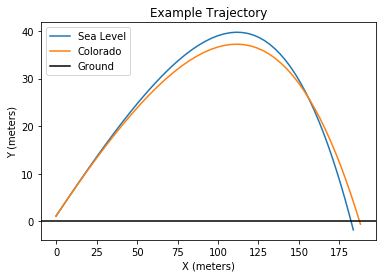

In [381]:
plt.plot(Seaclean[:,0],Seaclean[:,1],label='Sea Level')
plt.plot(Coclean[:,0],Coclean[:,1],label='Colorado')

plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.title("Example Trajectory")

plt.axhline(color="black",label='Ground')

plt.legend()
plt.savefig('Example Trajectory')